In [8]:
#IMPORTS

import os
import math
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#LOAD DATASET

DATA_ROOT = "/kaggle/input/satellite-property"

df = pd.read_excel(os.path.join(DATA_ROOT, "train.xlsx"))

# Log-transform the target variable to stabilize variance
# This is standard practice for house price prediction
df["log_price"] = np.log1p(df["price"])

#TABULAR FEATURE EXTRACTION

# Selected numerical features used for tabular modeling
# These capture size, quality, location, and neighborhood context
TAB_COLS = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement", "lat", "long",
    "sqft_living15", "sqft_lot15"
]

#TABULAR DATA PREPROCESSING

# Convert all tabular features to numeric
# Any non-numeric or malformed values are coerced to NaN
for col in TAB_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Replace missing values with 0
# This is safe here because features are later standardized
df[TAB_COLS] = df[TAB_COLS].fillna(0.0)

# Standardize tabular features to zero mean and unit variance
# This improves optimization stability for neural networks
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[TAB_COLS] = scaler.fit_transform(df[TAB_COLS])

# Up to this point, the notebook constitutes preprocessing.ipynb


# CUSTOM DATASET DEFINITION

class HouseDataset(Dataset):
    def __init__(self, df, img_dir, tab_cols, target_col, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tab_cols = tab_cols
        self.target_col = target_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Extract tabular features
        tab = torch.tensor(
            row[self.tab_cols].values.astype(np.float32),
            dtype=torch.float32
        )


        # Extract target value
        y = torch.tensor(row[self.target_col], dtype=torch.float32)

        # Load corresponding satellite image using property ID
        img_path = os.path.join(
            self.img_dir,
            f"{int(row['id'])}.png"
        )

        # If image exists, load and preprocess
        # Otherwise, return a zero tensor (safe fallback)
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)
        else:
            img = torch.zeros(3, 224, 224)

        return img, tab, y

# IMAGE PREPROCESSING

# Image transformations matching ImageNet-pretrained ResNet requirements
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# TRAIN-VALIDATION SPLIT

# Split dataset into training and validation sets
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42
)

# Directory containing satellite images
IMG_DIR = "/kaggle/input/satellite-property/train/train"

train_ds = HouseDataset(train_df, IMG_DIR, TAB_COLS, "log_price", transform)
val_ds   = HouseDataset(val_df,   IMG_DIR, TAB_COLS, "log_price", transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)


# MODEL TRAINING

# MULTIMODEL NEURAL NETWORK ARCHITECTURE

class MultimodalRegressor(nn.Module):
    def __init__(self, tab_dim):
        super().__init__()

        # Image encoder
        backbone = models.resnet18(weights="IMAGENET1K_V1")
        self.cnn = nn.Sequential(*list(backbone.children())[:-1])

        for p in self.cnn.parameters():
            p.requires_grad = False  # keep frozen initially

        # Tabular encoder
        self.tab_mlp = nn.Sequential(
            nn.Linear(tab_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Fusion head
        self.regressor = nn.Sequential(
            nn.Linear(512 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, img, tab):
        img_feat = self.cnn(img).squeeze(-1).squeeze(-1)
        tab_feat = self.tab_mlp(tab)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(fused).squeeze(1)

#TRAINING AND VALIDATION FUNCTIONS
        
def train_epoch(model, loader, optimizer, device):
    model.train()
    losses = []

    for img, tab, y in loader:
        img, tab, y = img.to(device), tab.to(device), y.to(device)

        optimizer.zero_grad()
        y_hat = model(img, tab)
        loss = nn.functional.mse_loss(y_hat, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)


def validate(model, loader, device):
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for img, tab, y in loader:
            img, tab = img.to(device), tab.to(device)
            y_hat = model(img, tab)

            preds.append(y_hat.cpu().numpy())
            trues.append(y.numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    rmse = math.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    return rmse, r2

# MODEL TRAINING LOOP

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultimodalRegressor(tab_dim=len(TAB_COLS)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_rmse = float("inf")

for epoch in range(15):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    rmse, r2 = validate(model, val_loader, device)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train MSE {train_loss:.4f} | "
        f"Val RMSE {rmse:.4f} | "
        f"Val R2 {r2:.4f}"
    )

    if rmse < best_rmse:
        best_rmse = rmse
        torch.save(model.state_dict(), "best_end_to_end.pt")


Epoch 01 | Train MSE 3.5106 | Val RMSE 0.8989 | Val R2 -1.9278
Epoch 02 | Train MSE 0.4120 | Val RMSE 0.5208 | Val R2 0.0170
Epoch 03 | Train MSE 0.1744 | Val RMSE 0.4014 | Val R2 0.4161
Epoch 04 | Train MSE 0.1298 | Val RMSE 0.3543 | Val R2 0.5450
Epoch 05 | Train MSE 0.0922 | Val RMSE 0.4106 | Val R2 0.3891
Epoch 06 | Train MSE 0.0821 | Val RMSE 0.3369 | Val R2 0.5886
Epoch 07 | Train MSE 0.0765 | Val RMSE 0.3648 | Val R2 0.5179
Epoch 08 | Train MSE 0.0751 | Val RMSE 0.3388 | Val R2 0.5840
Epoch 09 | Train MSE 0.0683 | Val RMSE 0.2785 | Val R2 0.7190
Epoch 10 | Train MSE 0.0620 | Val RMSE 0.2982 | Val R2 0.6779
Epoch 11 | Train MSE 0.0724 | Val RMSE 0.2688 | Val R2 0.7381
Epoch 12 | Train MSE 0.0727 | Val RMSE 0.3108 | Val R2 0.6499
Epoch 13 | Train MSE 0.0619 | Val RMSE 0.3354 | Val R2 0.5923
Epoch 14 | Train MSE 0.0644 | Val RMSE 0.2787 | Val R2 0.7186
Epoch 15 | Train MSE 0.0581 | Val RMSE 0.2756 | Val R2 0.7248


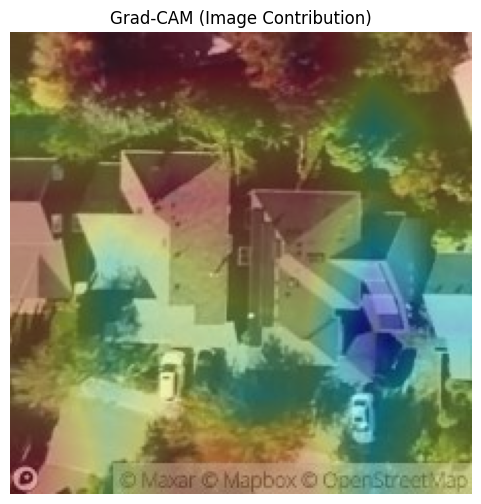

In [20]:
#MODEL LOADING

model = MultimodalRegressor(tab_dim=len(TAB_COLS)).to(device)
model.load_state_dict(torch.load("best_end_to_end.pt", map_location=device))
model.eval()

# ENABLING GRADIENTS FOR Grad-CAM

for p in model.cnn[-2][-1].conv2.parameters():
    p.requires_grad = True

# GRAD-CAM IMPLEMENTATION

import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

def gradcam_no_hooks(model, img, tab):
    """
    Returns CAM of shape (H, W)
    """
    model.zero_grad()

    # Forward until last conv
    x = img
    for layer in model.cnn[:-1]:   # everything before avgpool
        x = layer(x)

    activations = x               # [1, C, H, W]
    activations.retain_grad()     # retain gradients for Grad-CAM

    pooled = model.cnn[-1](x)     # avgpool
    pooled = pooled.view(pooled.size(0), -1)

    tab_feat = model.tab_mlp(tab)
    fused = torch.cat([pooled, tab_feat], dim=1)

    output = model.regressor(fused)
    output.backward()

    grads = activations.grad      # [1, C, H, W]

    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * activations).sum(dim=1)
    cam = F.relu(cam)

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    return cam[0].detach().cpu().numpy()

# GRAD-CAM VISUALISATION ON A VALIDATION SAMPLE

img, tab, y = val_ds[0]

img = img.unsqueeze(0).to(device)
tab = tab.unsqueeze(0).to(device)

cam = gradcam_no_hooks(model, img, tab)

# OVERLAYING GRAD-CAM ON SATELLITE IMAGE

img_np = img[0].cpu().permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

cam_resized = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

overlay = 0.4 * heatmap / 255 + img_np
overlay = overlay / overlay.max()

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM (Image Contribution)")
plt.show()


In [5]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import StandardScaler

# Load TRAIN data again (for scaler only)
TRAIN_XLSX = "/kaggle/input/satellite-property/train.xlsx"
train_df = pd.read_excel(TRAIN_XLSX)

TAB_COLS = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot",
    "floors", "waterfront", "view", "condition", "grade",
    "sqft_above", "sqft_basement", "lat", "long",
    "sqft_living15", "sqft_lot15"
]

# Force numeric (same as training)
for col in TAB_COLS:
    train_df[col] = pd.to_numeric(train_df[col], errors="coerce")

train_df[TAB_COLS] = train_df[TAB_COLS].fillna(0.0)

scaler = StandardScaler()
scaler.fit(train_df[TAB_COLS])

# Loading and preprocessing TEST data
TEST_XLSX = "/kaggle/input/satellite-test/test2.xlsx"
test_df = pd.read_excel(TEST_XLSX)

# Apply SAME preprocessing
for col in TAB_COLS:
    test_df[col] = pd.to_numeric(test_df[col], errors="coerce")

test_df[TAB_COLS] = test_df[TAB_COLS].fillna(0.0)

IMG_DIR   = "/kaggle/input/satellite-test/test/test"

print("Test rows:", len(test_df))

# Force numeric
for col in TAB_COLS:
    test_df[col] = pd.to_numeric(test_df[col], errors="coerce")

test_df[TAB_COLS] = test_df[TAB_COLS].fillna(0.0)

# IMPORTANT: use the SAME scaler from training
test_df[TAB_COLS] = scaler.transform(test_df[TAB_COLS])

#TEST DATASET DEFINITION
class TestDataset(Dataset):
    def __init__(self, df, img_dir, tab_cols, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tab_cols = tab_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        tab = torch.tensor(
            row[self.tab_cols].values.astype(np.float32),
            dtype=torch.float32
        )

        img_path = os.path.join(
            self.img_dir,
            f"{int(row['id'])}.jpg"
        )

        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)
        else:
            img = torch.zeros(3, 224, 224)

        return img, tab

# Image preprocessing identical to training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_ds = TestDataset(test_df, IMG_DIR, TAB_COLS, transform)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

MODEL_PATH = "/kaggle/input/satellite-property-model/best_end_to_end.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MultimodalRegressor(tab_dim=len(TAB_COLS)).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


preds = []

with torch.no_grad():
    for img, tab in test_loader:
        img = img.to(device)
        tab = tab.to(device)

        y_hat = model(img, tab)
        preds.append(y_hat.cpu().numpy())

preds = np.concatenate(preds)

test_df["predicted_price"] = np.expm1(preds)

submission = test_df[["id", "predicted_price"]]
submission.to_csv("submission.csv", index=False)

submission.head()



Test rows: 5404
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s] 


,id,predicted_price
0,2591820310,3.842286e+05
1,7974200820,8.661636e+05
2,7701450110,1.362049e+06
3,9522300010,2.787934e+06
4,9510861140,7.452929e+05
